In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#Graph configurations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

#Loading the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/rideshare_kaggle.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Loaded 693,071 rides!


In [4]:
#Simple inspections of the data

print(f"\n[1.1] Dataset Dimensions:")
print(f"  • Rows (rides): {df.shape[0]:,}")
print(f"  • Columns (features): {df.shape[1]}")
print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n[1.2] Column Overview:")
print(f"{'#':<4} {'Column Name':<35} {'Data Type':<15} {'Non-Null Count':<15}")
print("-" * 80)
for i, (col, dtype) in enumerate(df.dtypes.items(), 1):
    non_null = df[col].notna().sum()
    print(f"{i:<4} {col:<35} {str(dtype):<15} {non_null:,}")

print(f"\n[1.3] First 3 Rows:")
print(df.head(3).T)


[1.1] Dataset Dimensions:
  • Rows (rides): 693,071
  • Columns (features): 57
  • Memory usage: 725.08 MB

[1.2] Column Overview:
#    Column Name                         Data Type       Non-Null Count 
--------------------------------------------------------------------------------
1    id                                  object          693,071
2    timestamp                           float64         693,071
3    hour                                int64           693,071
4    day                                 int64           693,071
5    month                               int64           693,071
6    datetime                            object          693,071
7    timezone                            object          693,071
8    source                              object          693,071
9    destination                         object          693,071
10   cab_type                            object          693,071
11   product_id                          object          693,071

In [ ]:
#Inspecting the quality of the data
print("\n[2.1] Missing Values:")
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Pct': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Pct', ascending=False)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("✓ No missing values!")

Distribution:
  • Uber: 385,663 rides (55.6%)
  • Lyft: 307,408 rides (44.4%)


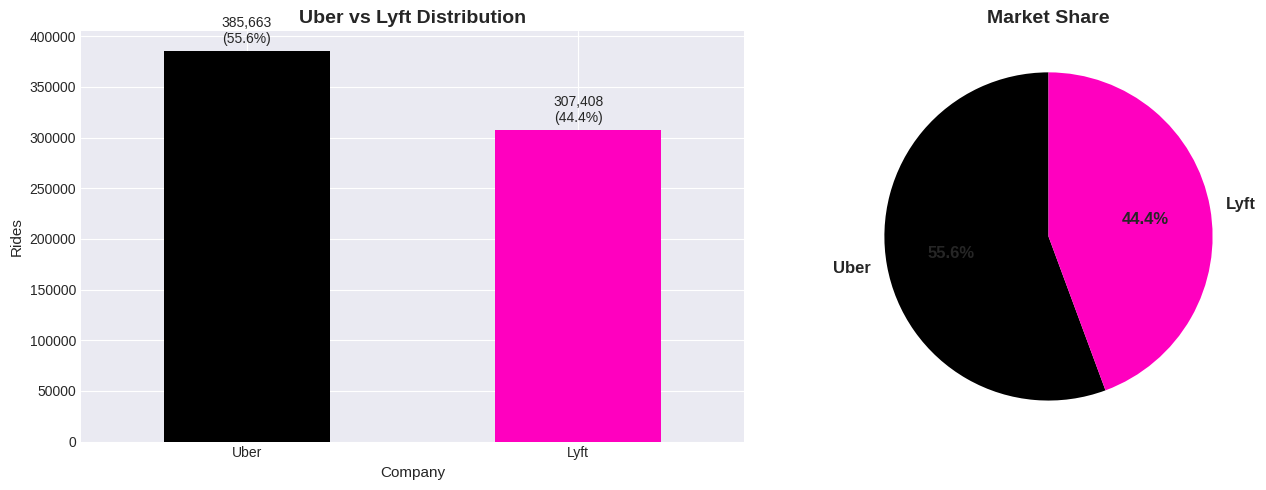

In [6]:
#Uber and Lyft statistics

cab_counts = df['cab_type'].value_counts()
print("Distribution:")
for cab, count in cab_counts.items():
    pct = count / len(df) * 100
    print(f"  • {cab}: {count:,} rides ({pct:.1f}%)")

#Figure 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'Uber': '#000000', 'Lyft': '#FF00BF'}

cab_counts.plot(kind='bar', ax=axes[0], color=[colors[x] for x in cab_counts.index])
axes[0].set_title('Uber vs Lyft Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Company', fontsize=11)
axes[0].set_ylabel('Rides', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
for i, v in enumerate(cab_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom')

axes[1].pie(cab_counts.values, labels=cab_counts.index, autopct='%1.1f%%',
           colors=[colors[x] for x in cab_counts.index], startangle=90,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Market Share', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


[4.1] Price Coverage: 637,976 rides (92.1%)

[4.2] Overall Statistics:
count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

[4.3] By Company:
           mean  median    std
cab_type                      
Lyft      17.35    16.5  10.02
Uber      15.80    12.5   8.56
Uber is 9.0% cheaper than Lyft


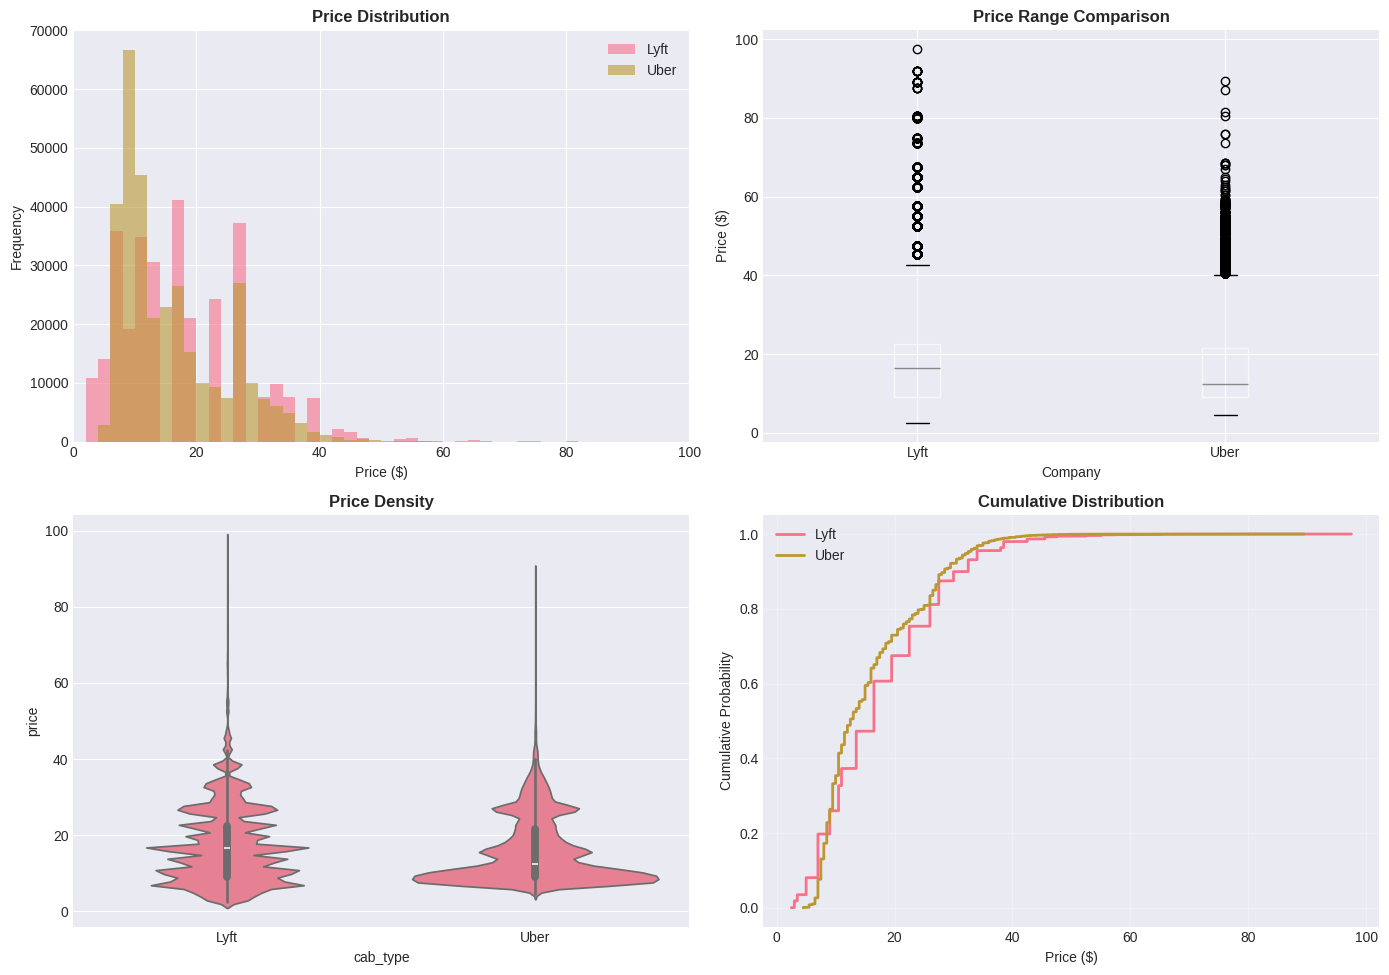

In [8]:
#Pricing analysis
df_priced = df.dropna(subset=['price'])
print(f"\n[4.1] Price Coverage: {len(df_priced):,} rides ({len(df_priced)/len(df)*100:.1f}%)")

print(f"\n[4.2] Overall Statistics:")
print(df_priced['price'].describe())

print(f"\n[4.3] By Company:")
price_stats = df_priced.groupby('cab_type')['price'].agg(['mean', 'median', 'std']).round(2)
print(price_stats)

uber_mean = df_priced[df_priced['cab_type']=='Uber']['price'].mean()
lyft_mean = df_priced[df_priced['cab_type']=='Lyft']['price'].mean()
price_diff = ((uber_mean - lyft_mean) / lyft_mean) * 100
print(f"Uber is {abs(price_diff):.1f}% {'cheaper' if price_diff < 0 else 'more expensive'} than Lyft")

#Figure 2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Histogram
for cab in df_priced['cab_type'].unique():
    data = df_priced[df_priced['cab_type'] == cab]['price']
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=cab, range=(0, 100))
axes[0, 0].set_title('Price Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 100)

#Boxplot
df_priced[df_priced['price'] <= 100].boxplot(column='price', by='cab_type', ax=axes[0, 1])
axes[0, 1].set_title('Price Range Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Company')
axes[0, 1].set_ylabel('Price ($)')
plt.suptitle('')

#Violin plot
sns.violinplot(data=df_priced[df_priced['price'] <= 100], x='cab_type', y='price', ax=axes[1, 0])
axes[1, 0].set_title('Price Density', fontsize=12, fontweight='bold')

#Cumulative distribution function
for cab in df_priced['cab_type'].unique():
    data = np.sort(df_priced[(df_priced['cab_type']==cab) & (df_priced['price']<=100)]['price'])
    cdf = np.arange(1, len(data)+1) / len(data)
    axes[1, 1].plot(data, cdf, label=cab, linewidth=2)
axes[1, 1].set_title('Cumulative Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Price ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Unique Locations:
  • Pickup: 12
  • Dropoff: 12
Top 10 Pickup Locations:
   1. Financial District             58,857 (8.5%)
   2. Theatre District               57,813 (8.3%)
   3. Back Bay                       57,792 (8.3%)
   4. Boston University              57,764 (8.3%)
   5. North End                      57,763 (8.3%)
   6. Fenway                         57,757 (8.3%)
   7. Northeastern University        57,756 (8.3%)
   8. South Station                  57,750 (8.3%)
   9. Haymarket Square               57,736 (8.3%)
  10. West End                       57,562 (8.3%)
Top 10 Dropoff Locations:
   1. Financial District             58,851 (8.5%)
   2. Theatre District               57,798 (8.3%)
   3. Back Bay                       57,780 (8.3%)
   4. Haymarket Square               57,764 (8.3%)
   5. Boston University              57,764 (8.3%)
   6. Fenway                         57,757 (8.3%)
   7. North End                      57,756 (8.3%)
   8. Northeastern University    

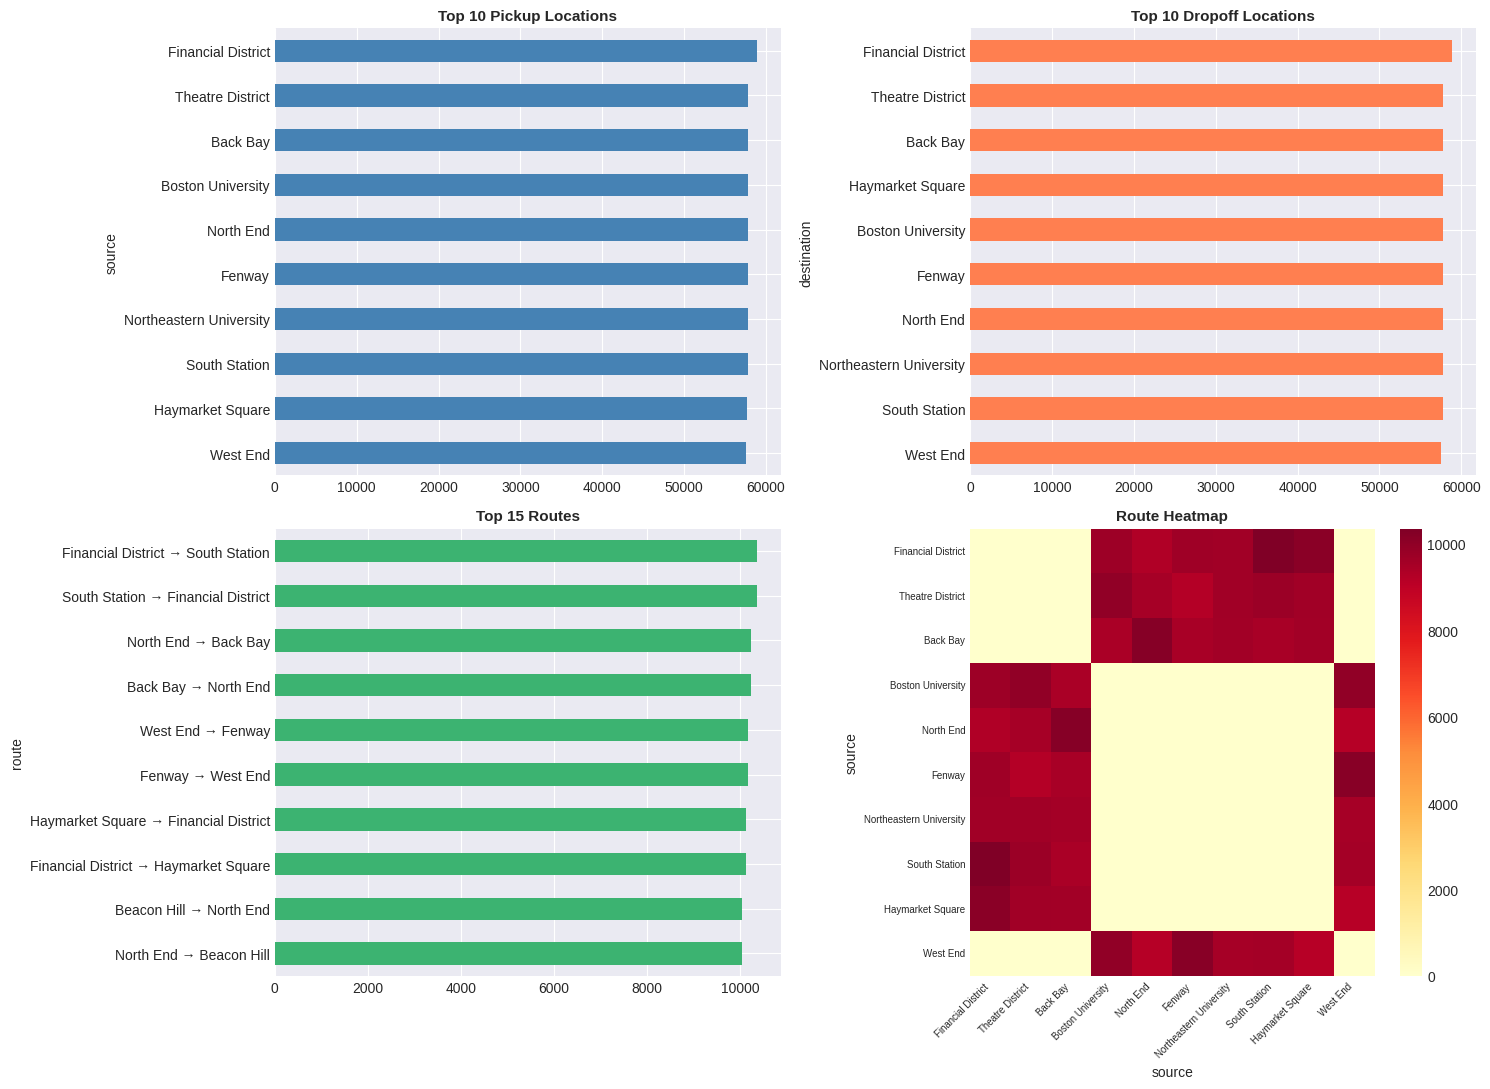

In [10]:
#Route and location analysis
print(f"Unique Locations:")
print(f"  • Pickup: {df['source'].nunique()}")
print(f"  • Dropoff: {df['destination'].nunique()}")

print(f"Top 10 Pickup Locations:")
top_sources = df['source'].value_counts().head(10)
for i, (loc, count) in enumerate(top_sources.items(), 1):
    print(f"  {i:2d}. {loc:<30} {count:>6,} ({count/len(df)*100:.1f}%)")

print(f"Top 10 Dropoff Locations:")
top_dests = df['destination'].value_counts().head(10)
for i, (loc, count) in enumerate(top_dests.items(), 1):
    print(f"  {i:2d}. {loc:<30} {count:>6,} ({count/len(df)*100:.1f}%)")

df['route'] = df['source'] + ' → ' + df['destination']
print(f"\n[5.4] Top 10 Routes:")
top_routes = df['route'].value_counts().head(10)
for i, (route, count) in enumerate(top_routes.items(), 1):
    print(f"  {i:2d}. {route:<55} {count:>5,}")

#Figure 3
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

top_sources.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Top 10 Pickup Locations', fontsize=11, fontweight='bold')
axes[0, 0].invert_yaxis()

top_dests.plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Top 10 Dropoff Locations', fontsize=11, fontweight='bold')
axes[0, 1].invert_yaxis()

top_routes.head(15).plot(kind='barh', ax=axes[1, 0], color='mediumseagreen')
axes[1, 0].set_title('Top 15 Routes', fontsize=11, fontweight='bold')
axes[1, 0].invert_yaxis()

route_matrix = pd.crosstab(df['source'], df['destination'])
top_locs = df['source'].value_counts().head(10).index
route_subset = route_matrix.loc[top_locs, top_locs]
sns.heatmap(route_subset, annot=False, cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Route Heatmap', fontsize=11, fontweight='bold')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=7)
plt.setp(axes[1, 1].get_yticklabels(), fontsize=7)

plt.tight_layout()
plt.show()

Surge Statistics:
  • With surge: 20,975 (3.0%)
  • No surge: 672,096 (97.0%)
  • Max surge: 3.0x
Surge increases price by 72.2% ($16.16 → $27.84)


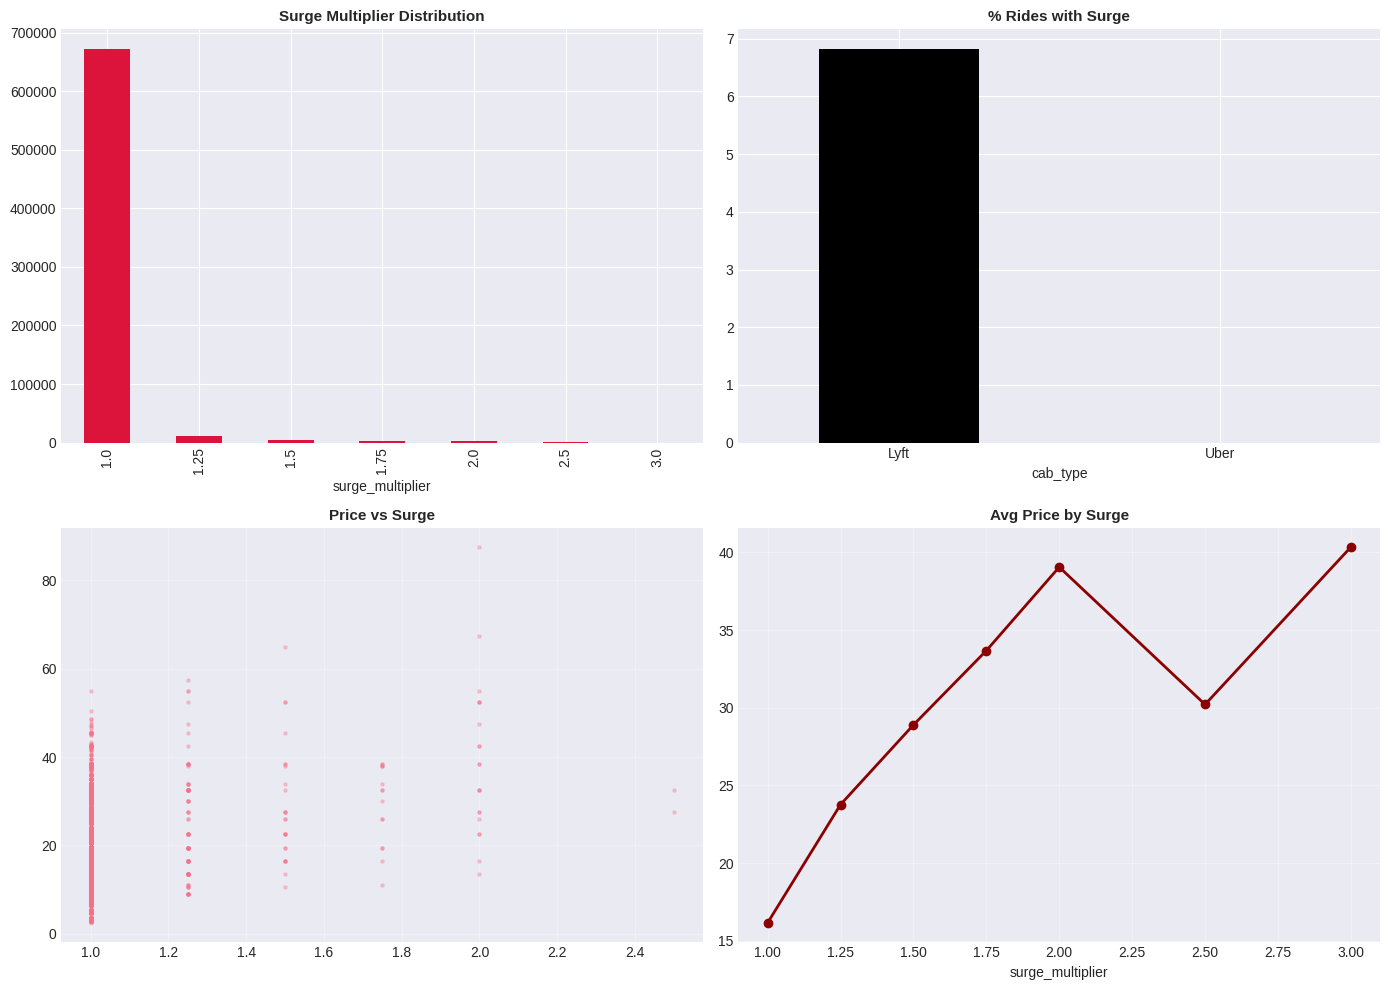

In [11]:
#Surge pricing analysis

surge_rides = df[df['surge_multiplier'] > 1.0]
print(f"Surge Statistics:")
print(f"  • With surge: {len(surge_rides):,} ({len(surge_rides)/len(df)*100:.1f}%)")
print(f"  • No surge: {len(df)-len(surge_rides):,} ({(len(df)-len(surge_rides))/len(df)*100:.1f}%)")
print(f"  • Max surge: {df['surge_multiplier'].max():.1f}x")

if len(df_priced) > 0:
    avg_no_surge = df_priced[df_priced['surge_multiplier']==1.0]['price'].mean()
    avg_surge = df_priced[df_priced['surge_multiplier']>1.0]['price'].mean()
    surge_impact = ((avg_surge - avg_no_surge) / avg_no_surge) * 100
    print(f"Surge increases price by {surge_impact:.1f}% (${avg_no_surge:.2f} -> ${avg_surge:.2f})")

#Figure 4
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

surge_dist = df['surge_multiplier'].value_counts().sort_index()
surge_dist.plot(kind='bar', ax=axes[0, 0], color='crimson')
axes[0, 0].set_title('Surge Multiplier Distribution', fontsize=11, fontweight='bold')

surge_pct = df.groupby('cab_type').apply(lambda x: (x['surge_multiplier']>1.0).sum()/len(x)*100)
surge_pct.plot(kind='bar', ax=axes[0, 1], color=['#000000', '#FF00BF'])
axes[0, 1].set_title('% Rides with Surge', fontsize=11, fontweight='bold')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

if len(df_priced) > 0:
    sample = df_priced[df_priced['price']<=100].sample(min(5000, len(df_priced)))
    axes[1, 0].scatter(sample['surge_multiplier'], sample['price'], alpha=0.3, s=5)
    axes[1, 0].set_title('Price vs Surge', fontsize=11, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)

    price_by_surge = df_priced.groupby('surge_multiplier')['price'].mean()
    price_by_surge.plot(ax=axes[1, 1], marker='o', linewidth=2, color='darkred')
    axes[1, 1].set_title('Avg Price by Surge', fontsize=11, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Coverage:
  • Start: 2018-11-26 03:40:46
  • End: 2018-12-18 19:15:11
  • Days: 17
Peak Times:
  • Busiest hour: 0:00 (32,413 rides)
  • Busiest day: Tuesday (124,949 rides)


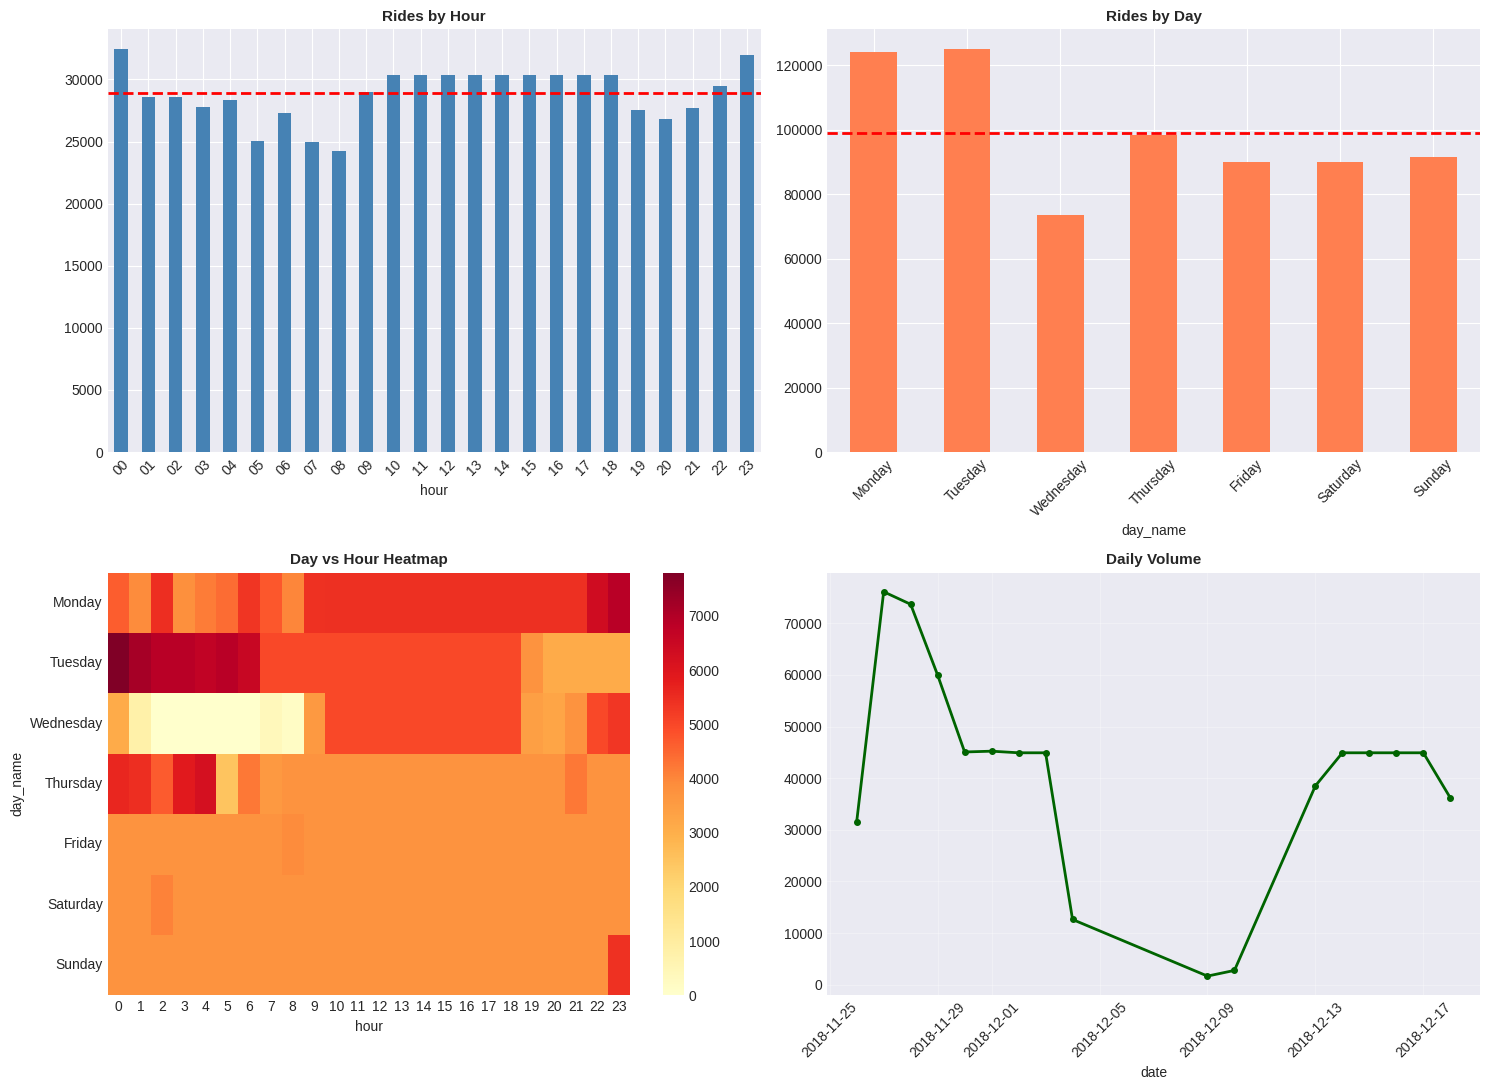

✓ Figure 5: Temporal Patterns


In [13]:
#Time analysis
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['day_name'] = df['datetime'].dt.day_name()
df['date'] = df['datetime'].dt.date

print(f"Coverage:")
print(f"  • Start: {df['datetime'].min()}")
print(f"  • End: {df['datetime'].max()}")
print(f"  • Days: {df['date'].nunique()}")

rides_by_hour = df.groupby('hour').size()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rides_by_day = df.groupby('day_name').size().reindex(day_order)

print(f"Peak Times:")
print(f"  • Busiest hour: {rides_by_hour.idxmax()}:00 ({rides_by_hour.max():,} rides)")
print(f"  • Busiest day: {rides_by_day.idxmax()} ({rides_by_day.max():,} rides)")

#Figure 5
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

rides_by_hour.plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Rides by Hour', fontsize=11, fontweight='bold')
axes[0, 0].axhline(rides_by_hour.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xticklabels([f'{h:02d}' for h in range(24)], rotation=45)

rides_by_day.plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Rides by Day', fontsize=11, fontweight='bold')
axes[0, 1].axhline(rides_by_day.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

heatmap_data = df.groupby(['day_name', 'hour']).size().unstack(fill_value=0).reindex(day_order)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Day vs Hour Heatmap', fontsize=11, fontweight='bold')

daily_rides = df.groupby('date').size()
daily_rides.plot(ax=axes[1, 1], linewidth=2, marker='o', markersize=4, color='darkgreen')
axes[1, 1].set_title('Daily Volume', fontsize=11, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Figure 5: Temporal Patterns")

Temperature:
  • Mean: 39.6°F
  • Range: 18.9°F - 57.2°F
Top Weather Conditions:
  1.  Overcast            218,895 (31.6%)
  2.  Mostly Cloudy       146,210 (21.1%)
  3.  Partly Cloudy       127,224 (18.4%)
  4.  Clear               87,126 (12.6%)
  5.  Light Rain          54,912 (7.9%)


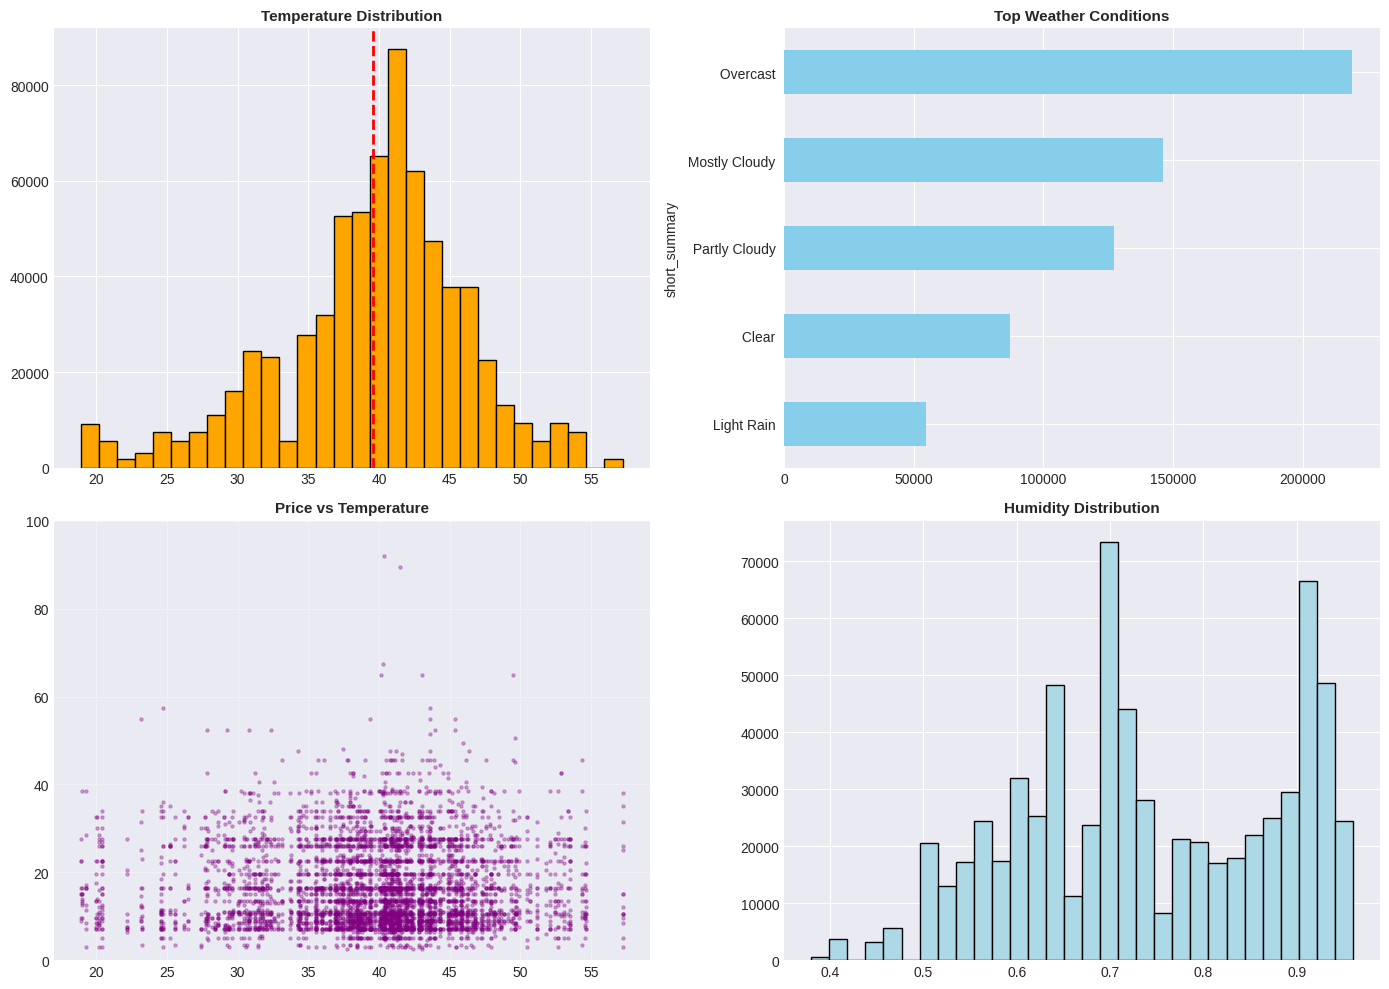

In [14]:
#Weather patterns
print(f"Temperature:")
print(f"  • Mean: {df['temperature'].mean():.1f}°F")
print(f"  • Range: {df['temperature'].min():.1f}°F - {df['temperature'].max():.1f}°F")

print(f"Top Weather Conditions:")
weather = df['short_summary'].value_counts().head(5)
for i, (cond, count) in enumerate(weather.items(), 1):
    print(f"  {i}. {cond:<20} {count:>6,} ({count/len(df)*100:.1f}%)")

#Figure 6
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df['temperature'], bins=30, color='orange', edgecolor='black')
axes[0, 0].set_title('Temperature Distribution', fontsize=11, fontweight='bold')
axes[0, 0].axvline(df['temperature'].mean(), color='red', linestyle='--', linewidth=2)

weather.head(6).plot(kind='barh', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Top Weather Conditions', fontsize=11, fontweight='bold')
axes[0, 1].invert_yaxis()

if len(df_priced) > 0:
    sample = df_priced.sample(min(5000, len(df_priced)))
    axes[1, 0].scatter(sample['temperature'], sample['price'], alpha=0.3, s=5, c='purple')
    axes[1, 0].set_title('Price vs Temperature', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylim(0, 100)
    axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(df['humidity'], bins=30, color='lightblue', edgecolor='black')
axes[1, 1].set_title('Humidity Distribution', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Statistics:
count    693071.000000
mean          2.189430
std           1.138937
min           0.020000
25%           1.280000
50%           2.160000
75%           2.920000
max           7.860000
Name: distance, dtype: float64
Categories:
  • <1mi: 89,490 (12.9%)
  • 1-3mi: 445,086 (64.2%)
  • 3-5mi: 147,347 (21.3%)
  • 5-10mi: 11,148 (1.6%)
  • >10mi: 0 (0.0%)
Price per Mile: $9.21/mi (avg)


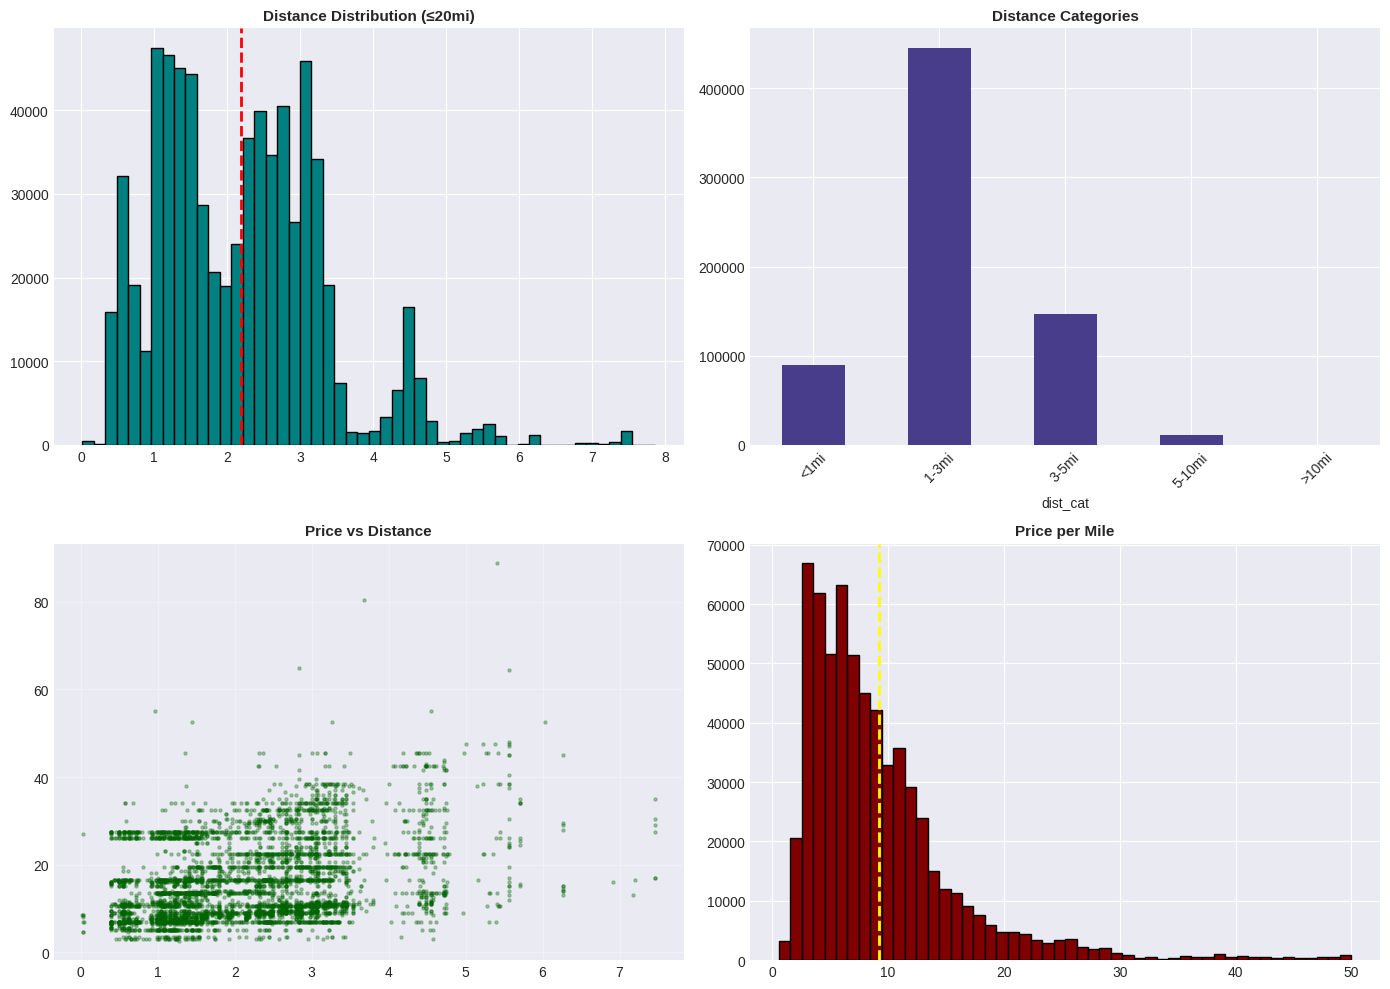

In [15]:
#Distance analysis
print(f"Statistics:")
print(df['distance'].describe())

df['dist_cat'] = pd.cut(df['distance'], bins=[0,1,3,5,10,100],
                        labels=['<1mi', '1-3mi', '3-5mi', '5-10mi', '>10mi'])
print(f"Categories:")
for cat, count in df['dist_cat'].value_counts().sort_index().items():
    print(f"  • {cat}: {count:,} ({count/len(df)*100:.1f}%)")

if len(df_priced) > 0:
    df_priced['price_per_mile'] = df_priced['price'] / df_priced['distance']
    ppm_clean = df_priced[(df_priced['price_per_mile']>0) & (df_priced['price_per_mile']<50)]
    print(f"Price per Mile: ${ppm_clean['price_per_mile'].mean():.2f}/mi (avg)")

#Figure 7
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df[df['distance']<=20]['distance'], bins=50, color='teal', edgecolor='black')
axes[0, 0].set_title('Distance Distribution (≤20mi)', fontsize=11, fontweight='bold')
axes[0, 0].axvline(df['distance'].mean(), color='red', linestyle='--', linewidth=2)

df['dist_cat'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], color='darkslateblue')
axes[0, 1].set_title('Distance Categories', fontsize=11, fontweight='bold')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

if len(df_priced) > 0:
    sample = df_priced[(df_priced['price']<=100) & (df_priced['distance']<=20)].sample(min(5000, len(df_priced)))
    axes[1, 0].scatter(sample['distance'], sample['price'], alpha=0.3, s=5, c='darkgreen')
    axes[1, 0].set_title('Price vs Distance', fontsize=11, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].hist(ppm_clean['price_per_mile'], bins=50, color='maroon', edgecolor='black')
    axes[1, 1].set_title('Price per Mile', fontsize=11, fontweight='bold')
    axes[1, 1].axvline(ppm_clean['price_per_mile'].mean(), color='yellow', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()